In [1]:
import cv2
import math
import numpy as np
from cv_bridge import CvBridge

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def rotate_image(image, angle, translation):
    ''' rotate image
    @params
    image : image
    angle : angle to rotate [deg]
    translation : move image
    
    @return
    new_image : rotated_image
    '''
    row,col = image.shape[:2]
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)   # center, angle[deg], ratio
    aff_mat = rot_mat.copy()
    aff_mat[:, 2] = translation
    print(aff_mat)
    image_rotated = cv2.warpAffine(image, aff_mat, (col,row))
    return image_rotated

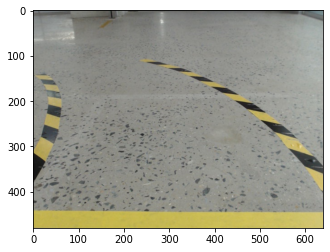

In [52]:
%matplotlib inline

# img = cv2.imread('images/front.jpg')
img = cv2.imread('front_ramp.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.flip(img, 1)
plt.imshow(img)

## HLS Transform
L : Lightness -> 검은색 검출(100 미만)    
S : Saturation -> 색깔 검출 (60이상 255 미만)

In [53]:
def threshold_hls(img_rgb, **kwargs):
    '''
    # Function Description
    Saturation Thresholding and binarization in HLS space
    
    # Parameter
    img_rgb               = RGB, undistorted image
    kwargs                = keyword arguments
    
    # kwargs
    verbose               = show both S channel image and undistorted image when verbose == True
    
    # Return
    combined_binary       = binarized image thresholded in Lightness & Saturation channel of HLS space 
    '''
    
    # Threshold light channel for black
    l_thresh_min = 0
    # l_thresh_max = 120
    l_thresh_max = -1
    
    
    # Threshold color channel
    s_thresh_min = 60
    s_thresh_max = 255

    # Note: img is the undistorted, RGB image
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combined binary image
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (s_binary == 1)] = 1
    
    for key, value in kwargs.items():
        if key == 'verbose' and value == True:
            color_binary = np.dstack((np.zeros_like(l_binary), l_binary, s_binary)) * 255
            
            f, ax = plt.subplots(2, 2, figsize = (16, 18))
            ax[0,0].imshow(l_binary, cmap='gray')
            ax[0,0].set_title('L Channel')
            ax[0,1].imshow(s_binary, cmap='gray')
            ax[0,1].set_title('S Binary')
            ax[1,0].imshow(color_binary)
            ax[1,0].set_title('Stacked Channel')
            ax[1,1].imshow(combined_binary, cmap='gray')
            ax[1,1].set_title('Combined Binary')
            plt.show()
    
    return combined_binary

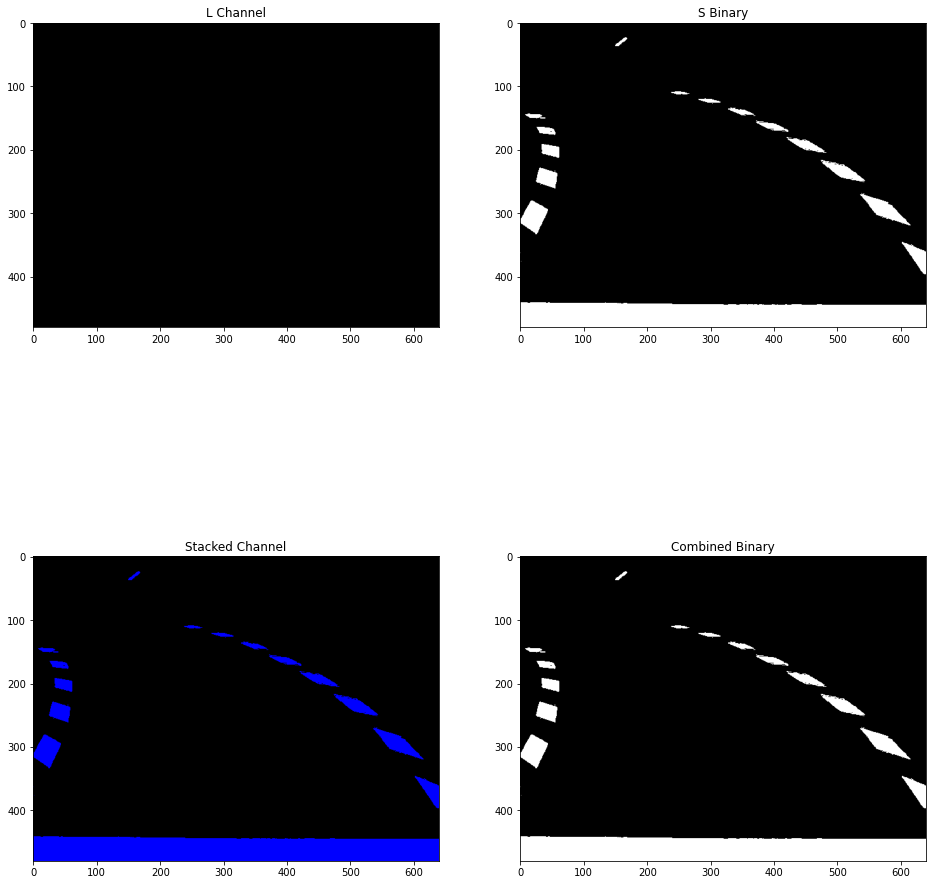

In [54]:
# How to Use
bin_img = threshold_hls(img, verbose=True)

## Perspective Change

In [88]:
def warp_perspective(img_bin, **kwargs):
    '''
    # Function Description
    Convert perspective of binary image to bird's view image
    
    # Parameter
    img_bin               = binary, thresholded image
    **kwargs              = keyword arguments
    
    # kwargs
    verbose               = show both S channel image and undistorted image when verbose == True
    
    # Return
    combined_binary       = warped image
    '''
    # Image size in (x, y) direction
    img_size = (img_bin.shape[1], img_bin.shape[0])
    
    # Height(h), Width(w) of image
    h, w = img_bin.shape[:2]

    # Original points(src) in image and destination of points(dst) in warped image
    src = np.float32([[625, 442],    # below right
                      [0,   442],    # below left
                      [149, 192],    # top   left
                      [478, 192]])   # top   right
    dst = np.float32([[439, 460],   # below right
                      [201, 460],   # below left
                      [201, 192],    # top   left
                      [439, 192]])   # top   right

    # Perspective Transform Matrix(M) and Inverse transform matrix(Minv)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image
    binary_warped = cv2.warpPerspective(img_bin, M, (img_size))
    
    ## Visualization ##
    for key, value in kwargs.items():
        if key == 'verbose' and value == True:
            img_roi = np.dstack((img_bin, img_bin, img_bin)) * 255
            img_roi = cv2.polylines(img_roi, [np.int32(src)], True, (255, 0, 0), 2)
            img_warped = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
            img_warped = cv2.polylines(img_warped, [np.int32(dst)], True, (255, 0, 0), 2)
            
            f, (ax1, ax2) = plt.subplots(1, 2, figsize = (32, 9))
            ax1.set_title('Before Warping', fontsize = 30)
            ax1.imshow(img_roi)
            ax2.set_title('After Warping', fontsize = 30)
            ax2.imshow(img_warped)
    return binary_warped, M, Minv

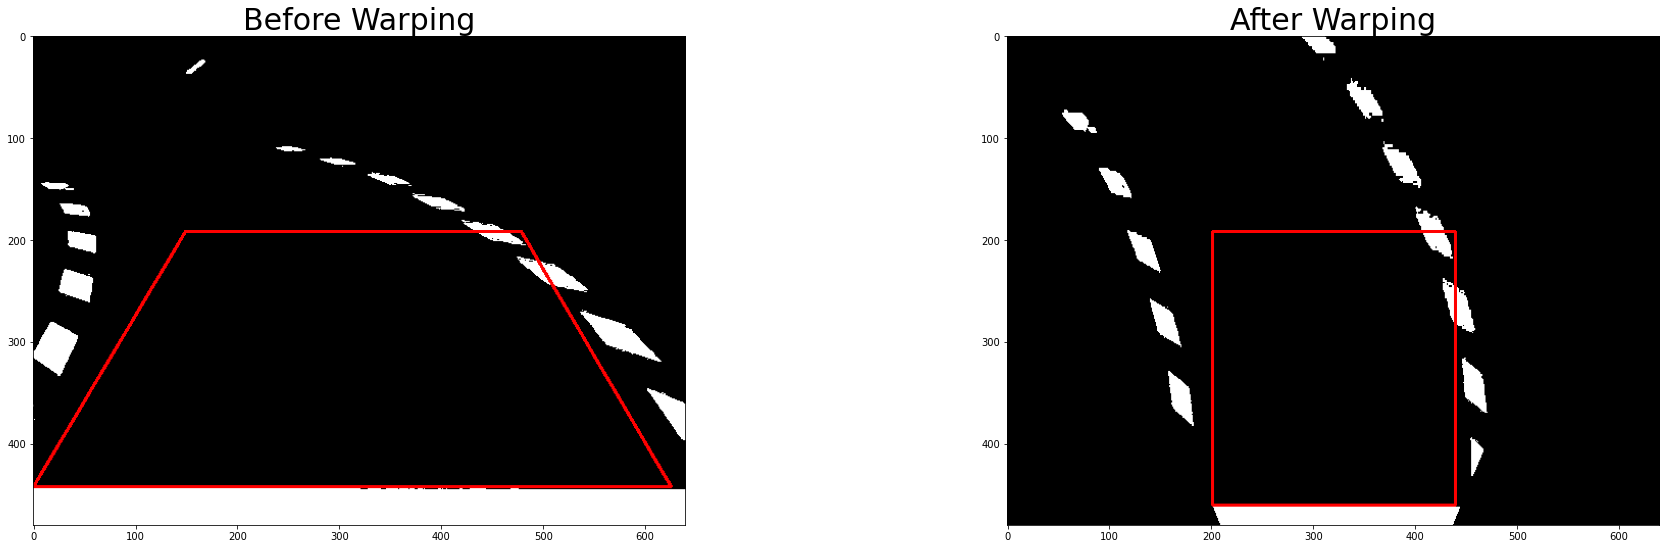

In [89]:
# how to use
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin, verbose = True)

## Detect lane pixels and fit to find the lane boundary

In [73]:
def detect_lane_pixels(img_warped, verbose = False):
    # 가장 아래 80 pixel 제거
    img_warped_croped = img_warped[:400, :]
    # plt.imshow(img_warped_croped, cmap='gray')
    
    # Image 교정용 Rotation
    img_warped_croped = rotate_image(img_warped_croped, 0, (0, 0))
    
    # HYPERPARAMETERS
    nwindows = 10           # Choose the number of sliding windows    
    margin = 50            # Set the width of the windows +/- margin
    minpix = 50            # Set minimum number of pixels found to recenter window

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_warped_croped.shape[0]//nwindows)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_warped_croped[img_warped_croped.shape[0]//2:img_warped_croped.shape[0],:], axis=0)

    # Visualize the resulting histogram
    # plt.plot(histogram)
    # plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    # nonzero
    nonzero = img_warped_croped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # [Visualization] Create an output image to draw on and visualize the result
    if verbose == True:
        out_img = np.dstack((img_warped_croped*255, img_warped_croped*255, img_warped_croped*255))
    
    # Step through the windows one by one
    # for window in range(nwindows):
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped_croped.shape[0] - (window+1)*window_height
        win_y_high = img_warped_croped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this

        # [Visualization] Draw the windows on the visualization image
        if verbose == True:
            cv2.rectangle(out_img,(win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their peak histogram ###
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if verbose == True:
        plt.figure(figsize = (24, 9))
        plt.imshow(out_img)
    
    return img_warped_croped, leftx, lefty, rightx, righty

[[ 1.  0.  0.]
 [-0.  1.  0.]]


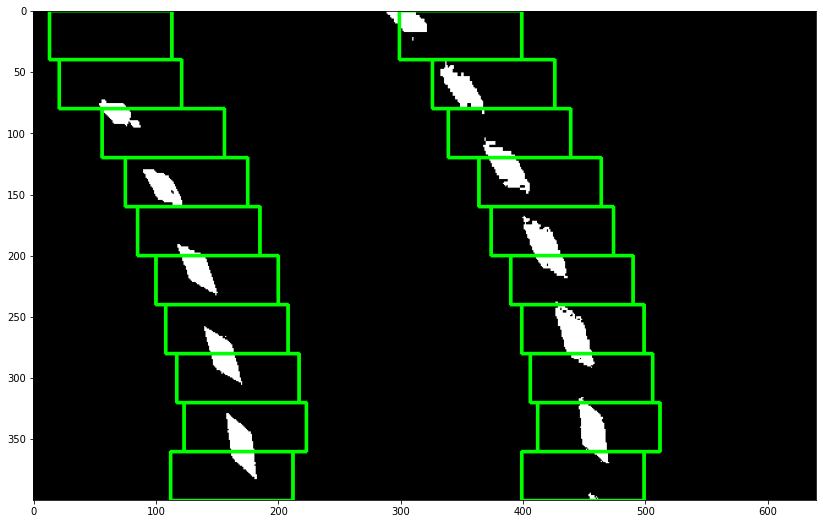

In [74]:
# how to use
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin)
img_warped_croped, leftx, lefty, rightx, righty = detect_lane_pixels(img_warped, verbose=True)

## Fit a polynomial

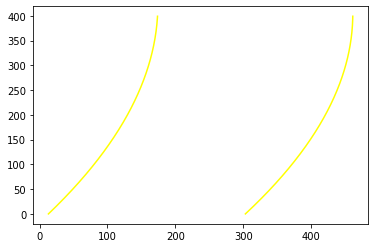

In [75]:
# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, img_warped_croped.shape[0]-1, img_warped_croped.shape[0] )
# print(ploty)
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

## Visualization ##
# Colors in the left and right lane regions
out_img = np.dstack((img_warped_croped*255, img_warped_croped*255, img_warped_croped*255))
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Visualization

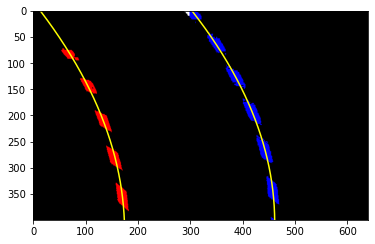

In [76]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

In [77]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_polyfit = np.polyfit(lefty, leftx, 2)
    right_polyfit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * (ploty ** 2) + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * (ploty ** 2) + right_fit[1] * ploty + right_fit[2]
    
    return left_polyfit, right_polyfit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, leftx, lefty, rightx, righty, verbose = False):
    # HYPERPARAMETER
    ## Choose the width of the margin around the previous polynomial to search
    margin = 10
    
    # polynomial fitting
    img_shape = binary_warped.shape
    left_polyfit, right_polyfit, _, _, _ = fit_poly(img_shape, leftx, lefty, rightx, righty)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty = \
        fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    if verbose == True:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.imshow(result)
        plt.show()
    ## End visualization steps ##
    
    return left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty

[[ 1.  0.  0.]
 [-0.  1.  0.]]


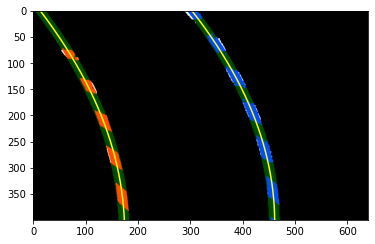

In [78]:
# how to use
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin)
img_warped_croped, leftx, lefty, rightx, righty = detect_lane_pixels(img_warped)
left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty \
= search_around_poly(img_warped_croped, leftx, lefty, rightx, righty, verbose = True)

## Radius of Curvature - pixel & real

In [79]:
def measure_curvature(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Hyper Parameter
    m_per_pix = 0.00252
    
    # Define y-value where we want radius of curvature
    # We'll choose the 0.75 * maximum y-value, corresponding to the 75% bottom of the image
    y_eval = np.int(np.max(ploty) * 0.75)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / (2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / (2*right_fit[0])
    
    left_curverad_real, right_curverad_real = (left_curverad* m_per_pix, right_curverad* m_per_pix) 
    
    return left_curverad_real, right_curverad_real

[[ 1.  0.  0.]
 [-0.  1.  0.]]


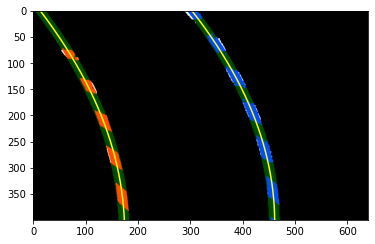

-1.531905096396098 -1.3855003589900399


In [80]:
# how to use
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin)
img_warped_croped, leftx, lefty, rightx, righty = detect_lane_pixels(img_warped)
left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty \
= search_around_poly(img_warped_croped, leftx, lefty, rightx, righty, verbose = True)

left_curverad_real, right_curverad_real = measure_curvature(ploty, left_polyfit_refined, right_polyfit_refined)
print(left_curverad_real, right_curverad_real)

## Distance From Center

In [81]:
def measure_distance_from_center(left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 0.00252 # meters per pixel in x dimension
    y_eval_pos_ratio = 0.9
    
    center_fitx = ((left_fitx + right_fitx) / 2 - 320) * xm_per_pix
    center_fit = np.array([center_fitx, ploty]).T
    
    # 아래로 75% 위치의 center로 부터의 거리 측정
    y_eval = np.int(np.max(ploty) * y_eval_pos_ratio)
    
    return center_fit[y_eval, 0]

[[ 1.  0.  0.]
 [-0.  1.  0.]]


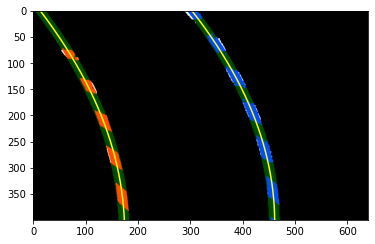

-1.531905096396098 -1.3855003589900399
-0.013046639523923362


In [82]:
# how to use
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin)
img_warped_croped, leftx, lefty, rightx, righty = detect_lane_pixels(img_warped)
left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty \
= search_around_poly(img_warped_croped, leftx, lefty, rightx, righty, verbose = True)

left_curverad_real, right_curverad_real = measure_curvature(ploty, left_polyfit_refined, right_polyfit_refined)
center_fit = measure_distance_from_center(left_fitx, right_fitx, ploty)
print(left_curverad_real, right_curverad_real)
print(center_fit)

## Stanley Controller

[[ 1.  0.  0.]
 [-0.  1.  0.]]


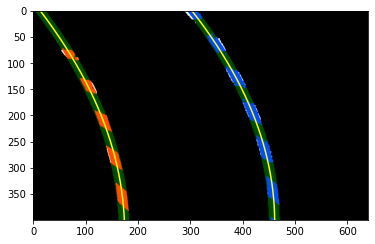

cross_track_error : -0.013046639523923362
Stanely Steering Angle: steer_ref + atan(gain_cte * cte)
-19.27 + -0.60 = -16.01 deg


In [84]:
# How to use

# Calculate the radius of curvature in pixels for both lane lines
img_bin = threshold_hls(img)
img_warped, M, Minv = warp_perspective(img_bin)
img_warped_croped, leftx, lefty, rightx, righty = detect_lane_pixels(img_warped)
left_polyfit_refined, right_polyfit_refined, left_fitx, right_fitx, ploty \
= search_around_poly(img_warped_croped, leftx, lefty, rightx, righty, verbose = True)

left_curverad_real, right_curverad_real = measure_curvature(ploty, left_polyfit_refined, right_polyfit_refined)

# Calcualte deviation from center (cross track error)
cross_track_error = measure_distance_from_center(left_fitx, right_fitx, ploty)

## Stanley 
# Calculate desired steering angle
wheel_base = 0.51    #[m]
gain_cte = 0.8
gain_str = 0.8

curverad_mean = (left_curverad_real + right_curverad_real)/2    #[m]
steer_ref = np.arctan(wheel_base/curverad_mean)

print("cross_track_error :", cross_track_error)

# calculate stanley steering angle
steer_stanley = gain_str * steer_ref + np.arctan(gain_cte * cross_track_error)
print("Stanely Steering Angle: steer_ref + atan(gain_cte * cte)")
print("{:.2f} + {:.2f} = {:.2f}".format(steer_ref*180/np.pi, np.arctan(gain_cte * cross_track_error)*180/np.pi, steer_stanley * 180/np.pi), 'deg')